# 04 Model Training

1. A baseline forecast (persistence)

2. A Ridge regression model (strong first ML model)

3. Evaluation metrics (MAE, RMSE)

4. Saved predictions for Notebook 05 backtesting/evaluation

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [68]:
train = pd.read_csv("../data_processed/train_regression.csv", index_col=0, parse_dates=True)
test  = pd.read_csv("../data_processed/test_regression.csv", index_col=0, parse_dates=True)

train.shape, test.shape


((3443, 20), (497, 20))

### 1. Define the features

In [69]:
target = "y_log"

exclude = ["y", "y_log"]
feature_cols = [col for col in train.columns if col not in exclude]

X_train = train[feature_cols]
y_train = train[target]

X_test = test[feature_cols]
y_test = test[target]

len(feature_cols), feature_cols


(18,
 ['realized_vol',
  'rv_lag1',
  'rv_lag5',
  'rv_lag20',
  'rv_change1',
  'rv_change5',
  'rv_mean5',
  'rv_mean20',
  'rv_mean60',
  'ret_lag1',
  'ret_lag5',
  'abs_ret',
  'abs_ret_mean5',
  'abs_ret_mean20',
  'vol_of_vol_20',
  'vol_of_vol_60',
  'drawdown_60',
  'ma_ratio_20_60'])

### 2. Baseline model
Since we assume volatility is persistent in base line so
- predict future volatility equals current realized volatility.

In [70]:
baseline_pred_log = np.log(test["realized_vol"])
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

baseline_mae_log = mean_absolute_error(y_test, baseline_pred_log)
baseline_rmse_log = rmse(y_test, baseline_pred_log)

baseline_mae_log, baseline_rmse_log

(0.14834675033226374, np.float64(0.21069399115704218))

### 3. Train Ridge regression
- we use ridge regression to prevent overfitting. 
- it shrink the coefficient towards 0 but add more bias

In [71]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

model.fit(X_train, y_train)

ridge_pred_log = model.predict(X_test)

ridge_mae_log = mean_absolute_error(y_test, ridge_pred_log)
ridge_rmse_log = rmse(y_test, ridge_pred_log)

ridge_mae_log, ridge_rmse_log

(0.17556520009223528, np.float64(0.24137309113900138))

### 4. Comparing the baseline vs the model
- model should outperform the baseline

In [72]:
results = pd.DataFrame({
    "model": ["baseline_persistence", "ridge_regression"],
    "MAE(log-vol)": [baseline_mae_log, ridge_mae_log],
    "RMSE(log-vol)": [baseline_rmse_log, ridge_rmse_log]
})

results

,model,MAE(log-vol),RMSE(log-vol)
0,baseline_persistence,0.148347,0.210694
1,ridge_regression,0.175565,0.241373


### 5. Tune Ridge alpha
- now the baseline outperforms the model so we must tune the model

In [73]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
rows = []

for a in alphas:
    m = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    rows.append({
        "alpha": a,
        "MAE(log-vol)": mean_absolute_error(y_test, pred),
        "RMSE(log-vol)": rmse(y_test, pred)
    })

pd.DataFrame(rows).sort_values("MAE(log-vol)")

,alpha,MAE(log-vol),RMSE(log-vol)
6,1000.000,0.171117,0.216952
5,100.000,0.172148,0.224853
4,10.000,0.173835,0.235016
3,1.000,0.175565,0.241373
2,0.100,0.175745,0.242359
1,0.010,0.175762,0.242465
0,0.001,0.175764,0.242475


the bigger alpha the better performs, but currently the baseline still outperform the model a lot, could be due to
- the volatility is very persistent
- the 5 days horizons is actually quite small
let's add the following new features in 02 to test for result:
- df["rv_mean5"] = rv.rolling(5).mean()
- df["rv_mean20"] = rv.rolling(20).mean()
- df["rv_mean60"] = rv.rolling(60).mean()

after rerun, model perform even worse meaning that the baseline is extremely persistent and we should try another algorithm

### 6. Using a non-linear model

In [74]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = HistGradientBoostingRegressor(max_depth=3, learning_rate=0.05, max_iter=500)
gbr.fit(X_train, y_train)
gbr_predict_log = gbr.predict(X_test)

gbr_mae = mean_absolute_error(y_test, gbr_predict_log)
gbr_rmse = rmse(y_test, gbr_predict_log)

print("Baseline delta MAE:", baseline_mae_log)
print("Baseline delta RMSE:", baseline_rmse_log)
print("GBR delta MAE:", gbr_mae)
print("GBR delta RMSE:", gbr_rmse)



Baseline delta MAE: 0.14834675033226374
Baseline delta RMSE: 0.21069399115704218
GBR delta MAE: 0.13807867069283694
GBR delta RMSE: 0.19125784151507336


In [75]:
results = pd.DataFrame({
    "model": ["baseline_persistence", "ridge", "gbr"],
    "MAE(log-vol)": [baseline_mae_log, ridge_mae_log, gbr_mae],
    "RMSE(log-vol)": [baseline_rmse_log, ridge_rmse_log, gbr_rmse]
})

results

,model,MAE(log-vol),RMSE(log-vol)
0,baseline_persistence,0.148347,0.210694
1,ridge,0.175565,0.241373
2,gbr,0.138079,0.191258


### 7. Convert GBR delta predictions back into actual volatility forecasts
- to check do GBR prediction in volatility beats the baseline

In [76]:


true_vol = test["y"].values                  # future vol in vol units
baseline_vol = test["realized_vol"].values   # persistence baseline in vol units

# we are logging so need to exponentiate the predictions to get back to vol units
ridge_pred_vol = np.exp(ridge_pred_log)
gbr_pred_vol = np.exp(gbr_predict_log)

summary_vol = pd.DataFrame({
    "model": ["baseline_persistence", "ridge", "gbr"],
    "MAE(vol)": [
        mean_absolute_error(true_vol, baseline_vol),
        mean_absolute_error(true_vol, ridge_pred_vol),
        mean_absolute_error(true_vol, gbr_pred_vol)
    ],
    "RMSE(vol)": [
        rmse(true_vol, baseline_vol),
        rmse(true_vol, ridge_pred_vol),
        rmse(true_vol, gbr_pred_vol)
    ]
})

summary_vol


,model,MAE(vol),RMSE(vol)
0,baseline_persistence,0.021680,0.041522
1,ridge,0.029905,0.068379
2,gbr,0.019927,0.034419


### 8. Plotting and saving

In [77]:
pred_df = pd.DataFrame(index=test.index)
pred_df["true_vol"] = true_vol
pred_df["baseline_vol"] = baseline_vol
pred_df["ridge_vol"] = ridge_pred_vol
pred_df["gbr_vol"] = gbr_pred_vol

pred_df.to_csv("../data_processed/predictions_regression.csv")
print("Saved: ../data_processed/predictions_regression.csv")


Saved: ../data_processed/predictions_regression.csv


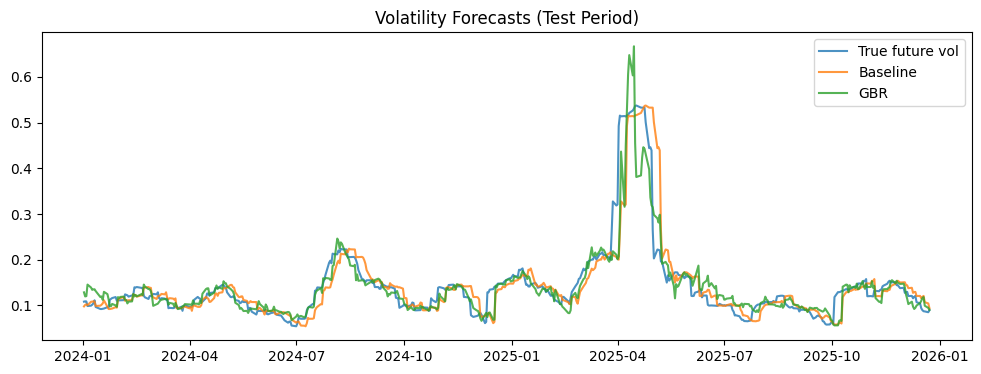

In [78]:
plt.figure(figsize=(12,4))
plt.plot(pred_df.index, pred_df["true_vol"], label="True future vol", alpha=0.8)
plt.plot(pred_df.index, pred_df["baseline_vol"], label="Baseline", alpha=0.8)
plt.plot(pred_df.index, pred_df["gbr_vol"], label="GBR", alpha=0.8)
plt.title("Volatility Forecasts (Test Period)")
plt.legend()
plt.show()


GBR only performs bad at the shock due to lack of event features to learn but bringing a 8% - 17% overall performance increase